In [1]:
from lib.modules.strategy import StrategyBase
from lib.model import Ohlcv
from typing import List
from datetime import datetime
from lib.utils.time import dt_to_ts, ts_to_dt

Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 486/486 [00:00<00:00, 3684.37it/s]


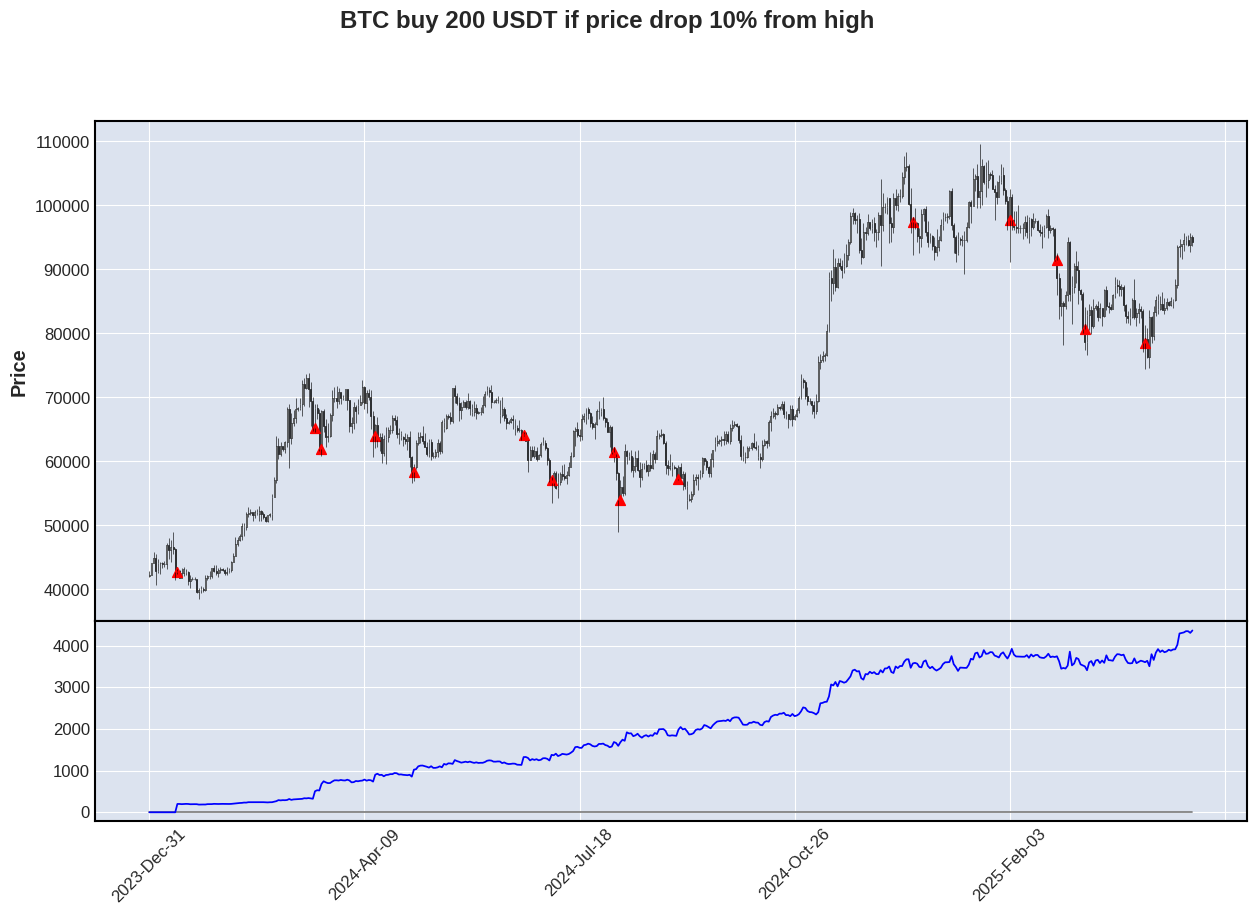

In [2]:

class SimpleStrategy(StrategyBase):
    def __init__(self, cost_each_time: float = 200):
        self.cost_each_time = cost_each_time

    def _core(self, ohlcv_list: List[Ohlcv]):
        if not self.state.get('last_event_time'):
            self.state.set('last_event_time', dt_to_ts(ohlcv_list[0].timestamp))
        # 上次出现最大回撤超过10%的时间
        last_event_time = ts_to_dt(self.state.get('last_event_time'))
        # 自上次出现最大回撤超过10%以来的最大价格
        high = max(filter(lambda x: x.timestamp >= last_event_time, ohlcv_list), key=lambda x: x.high)
        # 自上次出现最大回撤10%后到此刻是否出现最大回撤超过10%
        if high and (self.current_price - high.high) / high.high <= -0.1:
            self.logger.msg(f'price drop 10% from high {high.high} to {self.current_price} at {high.timestamp}')
            # 记录上次出现最大回撤超过10%的时间
            self.state.set('last_event_time', dt_to_ts(self.current_time))
            if self.investment == 0:
                # 没有设置初始本金，当场给自己发钱
                self.state.set('free_money', self.cost_each_time)
                self.buy(self.cost_each_time)
            elif self.free_money > 0:
                self.buy(self.cost_each_time if self.free_money >= 200 else self.free_money)

strategy = SimpleStrategy()
strategy.back_test(
    start_time=datetime(2024, 1, 1),
    end_time=datetime.now(),
    symbol='BTC/USDT',
    frame='1d',
    name='BTC buy 200 USDT if price drop 10% from high',
    investment=0
)



一共发生了15次回撤10%，我们花费了200 * 15 = 3000元， 看起来最终到了2025年4月底，我们的总资产为4500左右，一年多赚1500

如果这3000元当初一次性砸进去，对比我们的策略收益如何：

Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 486/486 [00:00<00:00, 3769.63it/s]


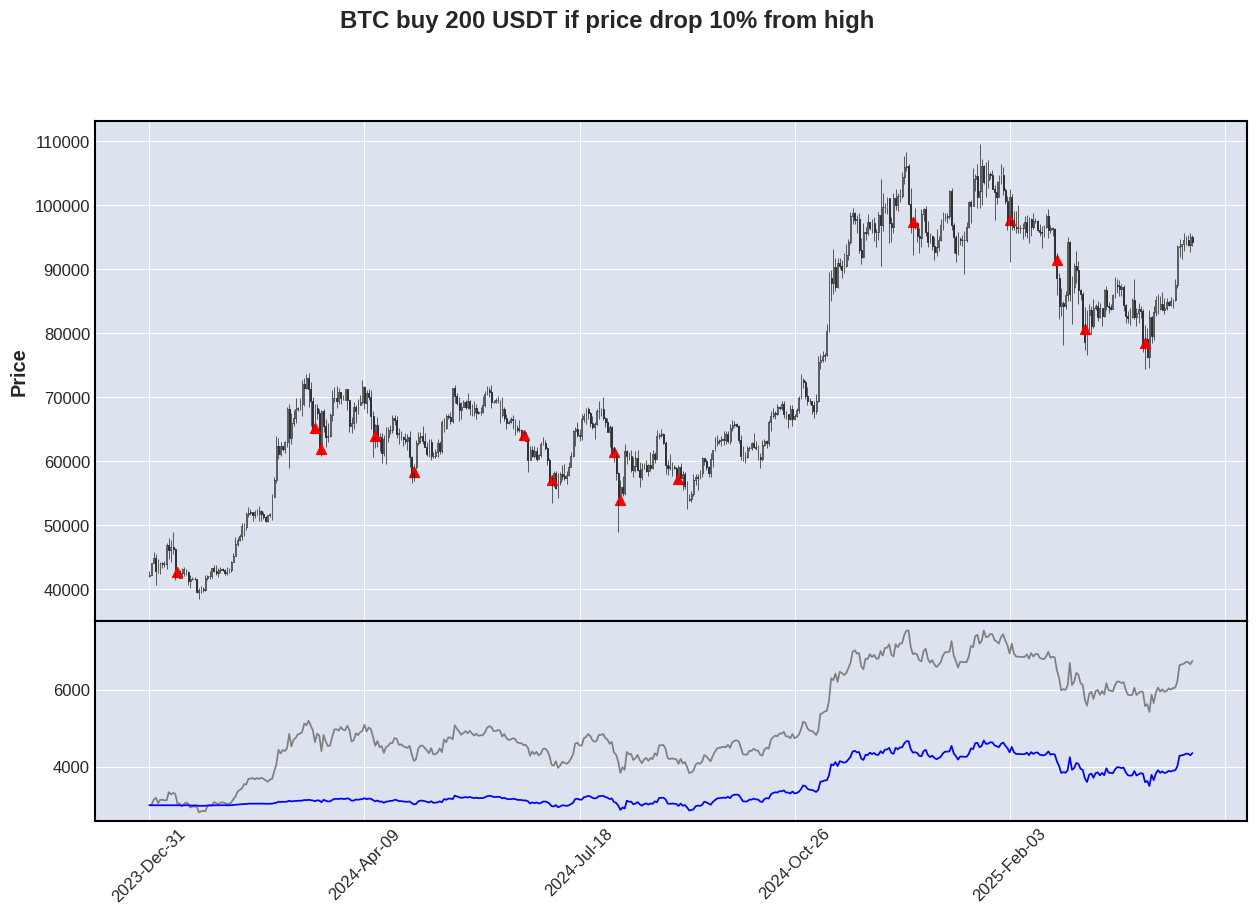

In [3]:
strategy.back_test(
    start_time=datetime(2024, 1, 1),
    end_time=datetime.now(),
    symbol='BTC/USDT',
    frame='1d',
    name='BTC buy 200 USDT if price drop 10% from high',
    investment=3000
)

可以看到我们一味的抄底，就这样错过了趋势，还不如当初一把梭呢，换成A股怎么样呢？那比亚迪的股票来做测试

Progress:   0%|                                                                                                    | 0/318 [00:00<?, ?it/s]

Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 318/318 [00:00<00:00, 3777.88it/s]
/home/jqlin/Project/quant/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65509 (\N{FULLWIDTH YEN SIGN}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


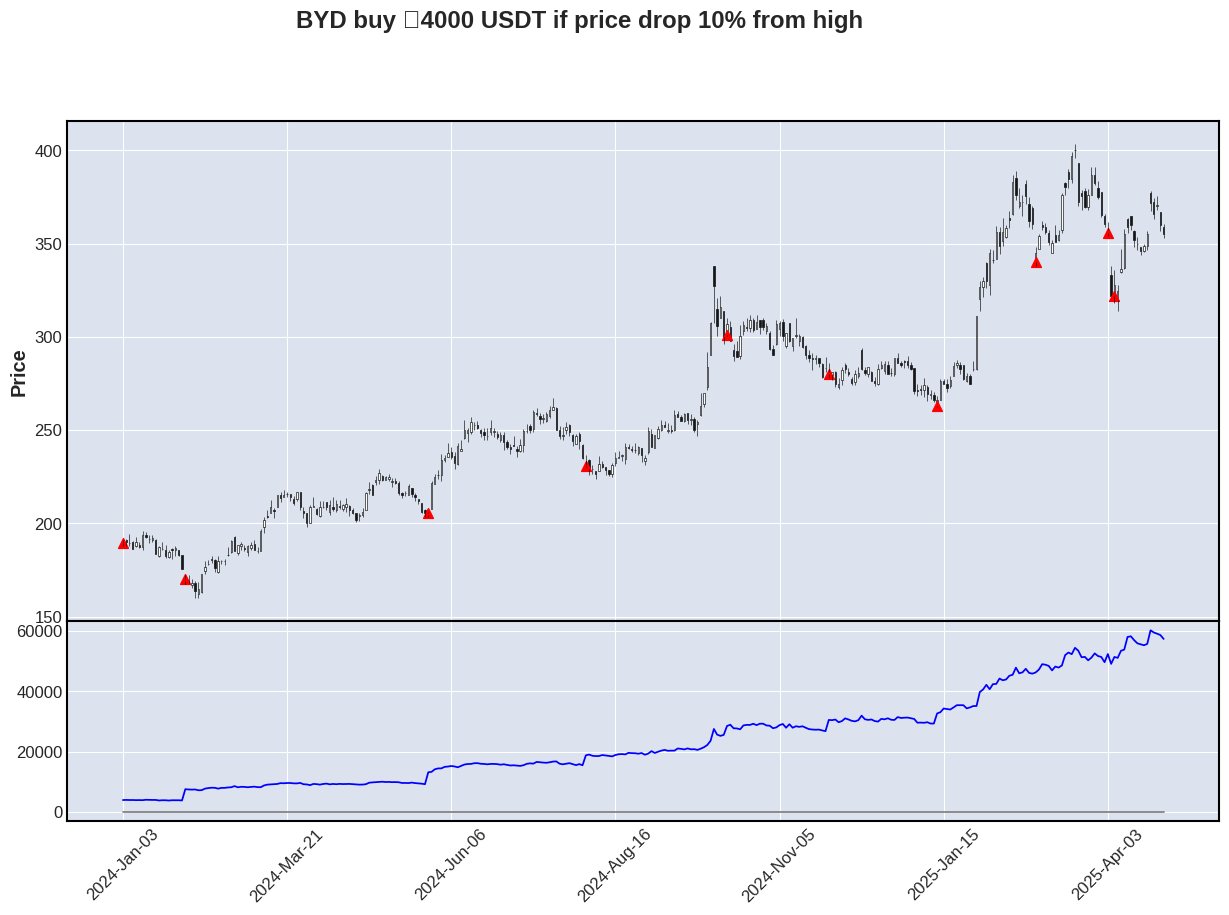

In [4]:
strategy = SimpleStrategy(cost_each_time=4000)
strategy.back_test(
    start_time=datetime(2024, 1, 1),
    end_time=datetime.now(),
    symbol='002594',
    frame='1d',
    name='BYD buy ￥4000 USDT if price drop 10% from high',
    investment=0
)

一共发生10次买入，花费4万元，最高总资产达到6万，来看看一把梭的收益

Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 318/318 [00:00<00:00, 2010.15it/s]
/home/jqlin/Project/quant/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65509 (\N{FULLWIDTH YEN SIGN}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


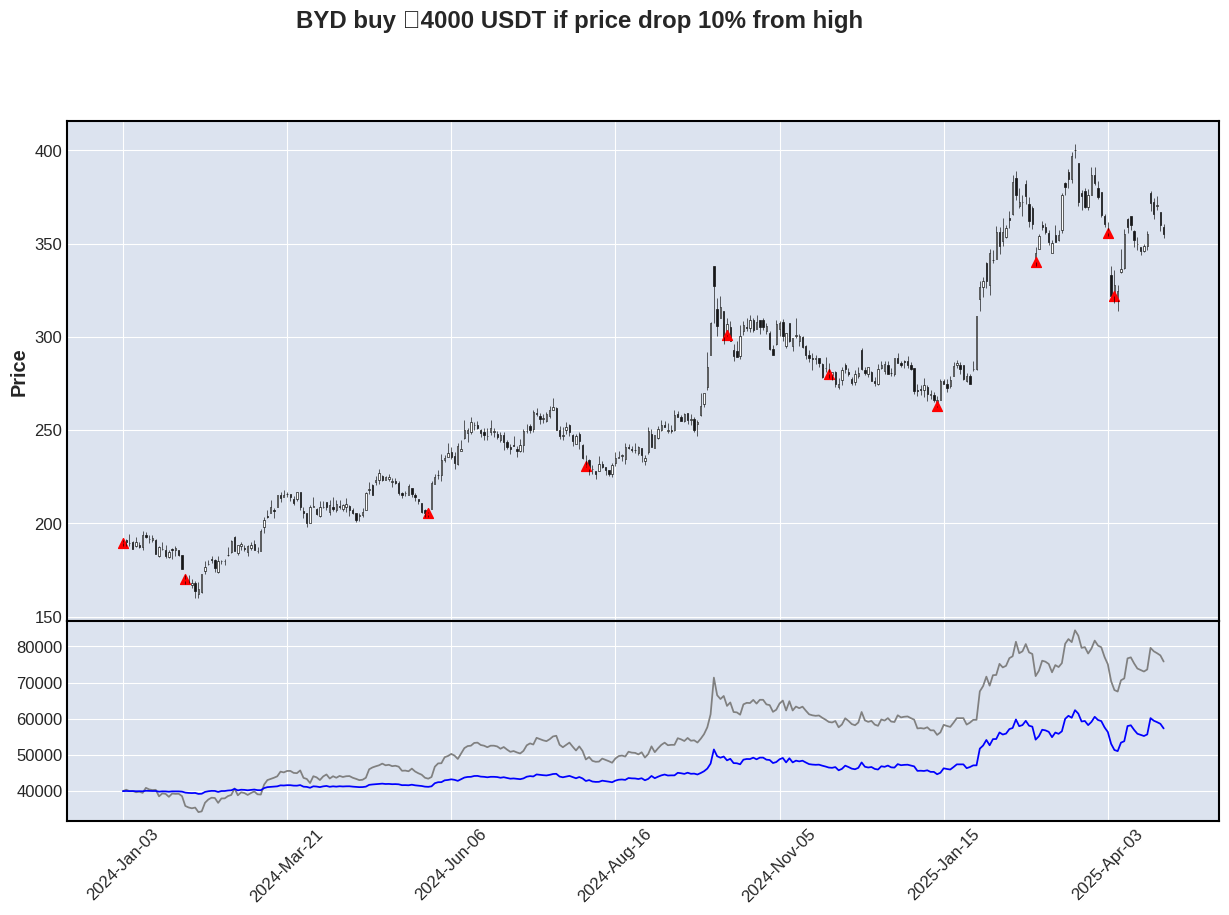

In [5]:
strategy.back_test(
    start_time=datetime(2024, 1, 1),
    end_time=datetime.now(),
    symbol='002594',
    frame='1d',
    name='BYD buy ￥4000 USDT if price drop 10% from high',
    investment=40000
)

上面的例子都是长期上涨的场景，这个策略有没有可能在长期波动的市场中也能盈利呢？看看以太坊的表现

Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 578/578 [00:00<00:00, 4416.23it/s]


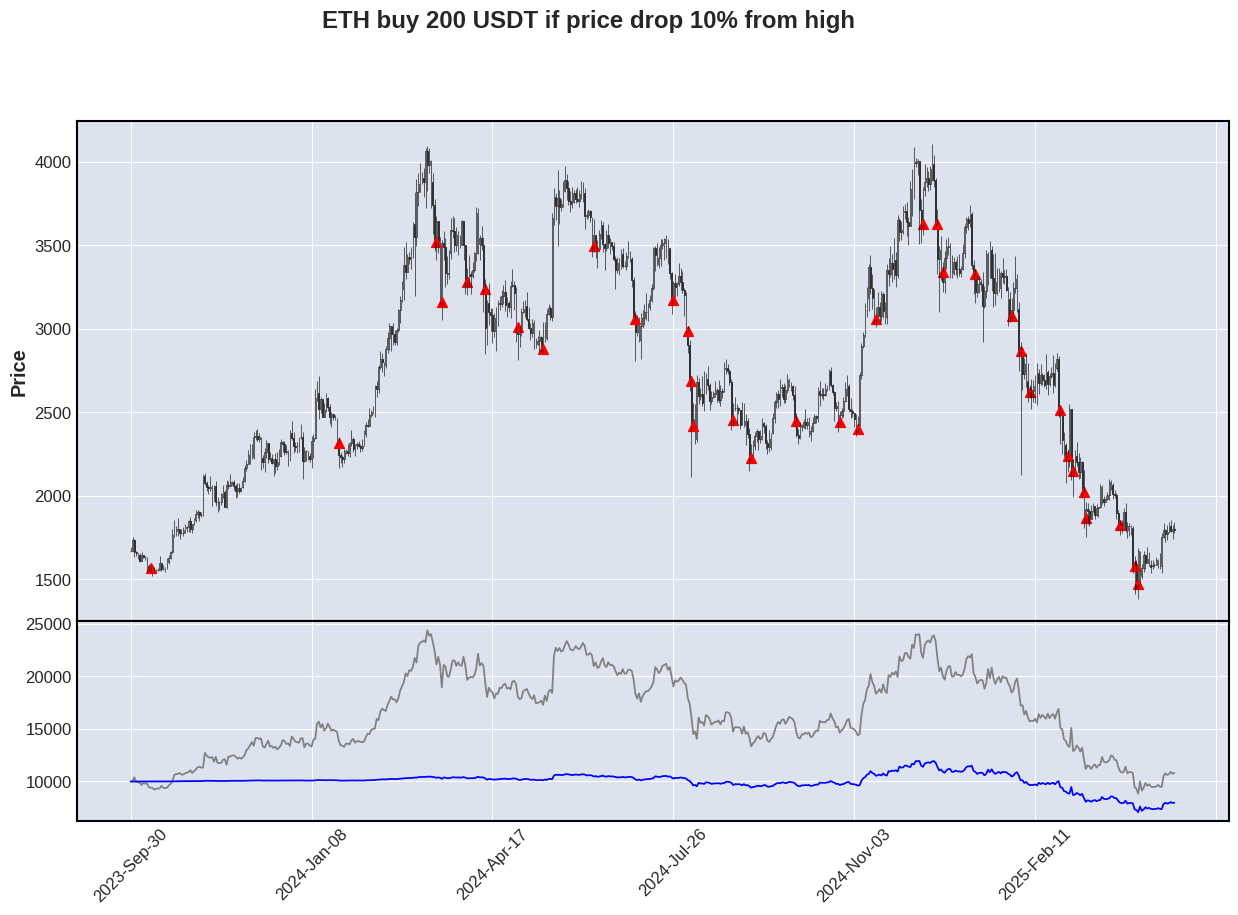

In [6]:
strategy = SimpleStrategy()
strategy.back_test(
    start_time=datetime(2023, 10, 1),
    end_time=datetime.now(),
    symbol='ETH/USDT',
    frame='1d',
    name='ETH buy 200 USDT if price drop 10% from high',
    investment=10000
)

怎么最后还亏了啊，还不如梭哈呢, 只有前面一小段跑赢了...到后面一味的抄底真就是个笑话了

Progress:   0%|                                                                                                    | 0/151 [00:00<?, ?it/s]

Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 151/151 [00:00<00:00, 2999.75it/s]


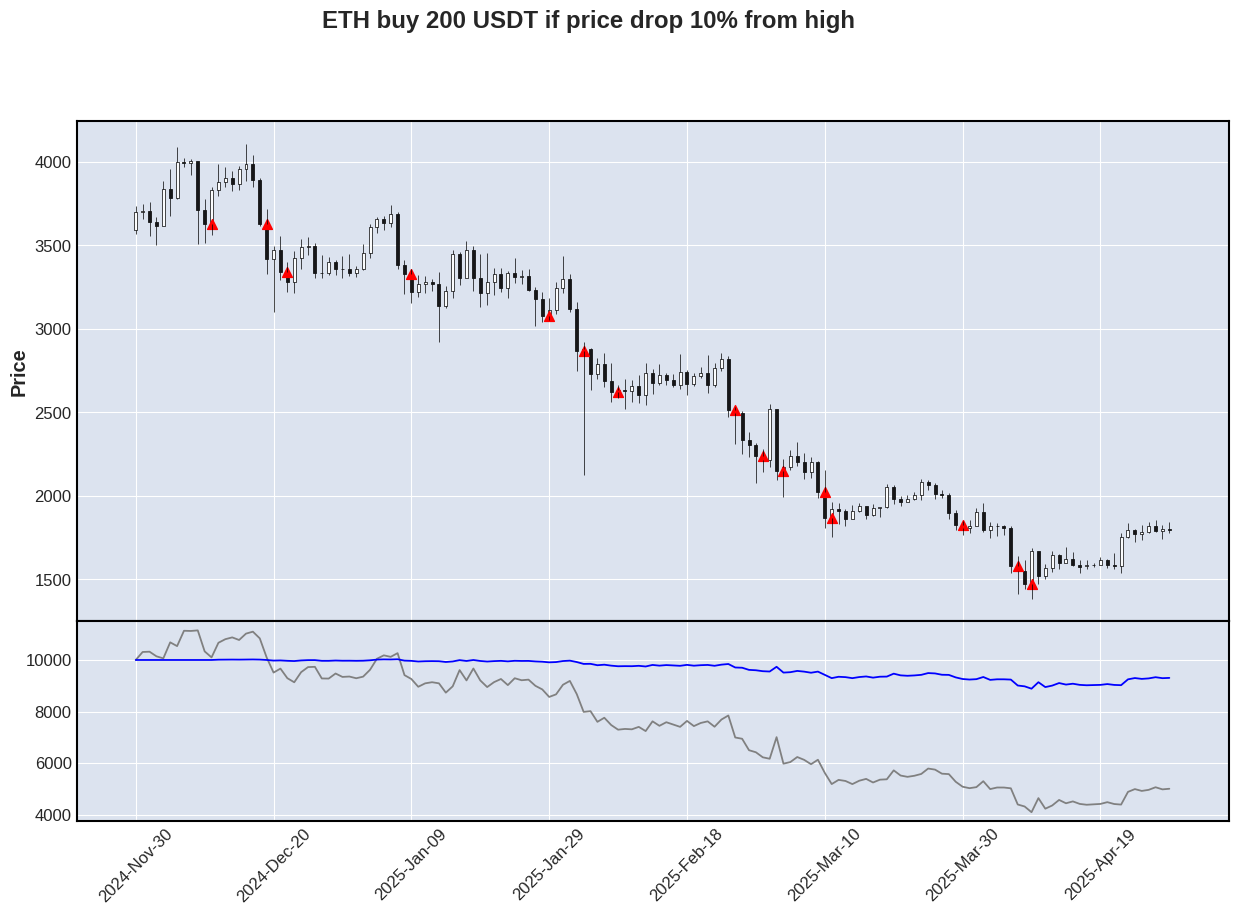

In [7]:
strategy.back_test(
    start_time=datetime(2024, 12, 1),
    end_time=datetime.now(),
    symbol='ETH/USDT',
    frame='1d',
    name='ETH buy 200 USDT if price drop 10% from high',
    investment=10000
)

不过在一直下跌的熊市行情，这个策略能让你少亏

结论：梭哈是一种智慧（狗头保命）